In [1]:
# an updated version of the uncertainty code that uses the different distribution 
# actually using keras models and trying to match the use of custom layers and losses.

In [2]:
#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from tensorflow import keras
%matplotlib inline
import pylab as pl
from IPython import display


import sys
sys.path.append("..") # Adds higher directory to python modules path.

import branchingdnn as branching
from branchingdnn import core
from branchingdnn.utils import * 
from branchingdnn.profiler import model_profiler as profiler
from branchingdnn.dataset import prepare
from branchingdnn.branches import branch

# from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [3]:
# Download MNIST dataset
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# print(y_train)
K= 10 # number of classes

In [4]:

train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels,10)

    
print(train_labels[0])
print((test_labels[0]))
# plt.imshow(train_images[1].reshape(228,228)) 
# plt.show()

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [5]:
validation_size = 1000
shuffle_size = 1000
batch_size=32
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))


def augment_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    # image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label
train_ds_size = len(list(train_ds))
test_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))
train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))

target = tf.data.Dataset.from_tensor_slices((train_labels))
train_ds = tf.data.Dataset.zip((train_ds,target))

v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))

t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))


print("trainSize {}".format(train_ds_size))
print("testSize {}".format(test_ds_size))
train_ds = (train_ds
                
                .shuffle(buffer_size=tf.cast(shuffle_size,'int64'))
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
               
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
               
                #   .shuffle(buffer_size=validation_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))

trainSize 49000
testSize 10000


In [6]:
# Create a LeNet network with softmax cross entropy loss function
def LeNet_softmax(lmb=0.005):
    inputs = keras.Input(shape=(227,227,3))
    
    x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
    x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(4096, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(4096, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(10, activation='softmax')(x)
    
    # model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
    model = keras.Model(inputs=inputs, outputs=[x], name="alexnet")

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
#     model.summary()
    return model
model = LeNet_softmax()

In [7]:
# model.fit(train_ds,
#           epochs=3,
#           validation_data=validation_ds,
#           validation_freq=1)
          


# model.evaluate(test_ds)


In [8]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

In [9]:
def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

def mse_loss(p, alpha, global_step, annealing_step): 
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    m = alpha / S
    
    A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

    annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
    
    alp = E*(1-p) + 1 
    # print("alp", alp)

    C =  annealing_coef * KL(alp)
    return (A + B) + C

def loss_function():
    #create a wrapper function that returns a function
    kl = tf.keras.losses.KLDivergence()
    temperature = 1
    Classes = 10
    crossE = tf.keras.losses.CategoricalCrossentropy()
    mse =mse_loss
    global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
    annealing_step = 320
    def EMSE_Loss(y_true, y_pred):
#         softmax = tf.nn.softmax(y_pred)
        evidence = exp_evidence(y_pred)
        alpha  = evidence + 1
        
        u = Classes / tf.reduce_sum(alpha, axis=1) #uncertainty
        
        prob = alpha/tf.reduce_sum(alpha, 1,keepdims=True) 
        
        loss = tf.reduce_mean(mse(y_true, alpha,global_step,annealing_step))
#         l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
#         l2_loss = tf.reduce_sum(tf.square(inputs - teaching_features))
        
        final_loss = loss #+ l2_loss
        
#         kl_loss = kl( tf.nn.softmax(softmax / self.temperature, axis = 1 ),
        
        return final_loss
        
    def EMSE_Loss_evidence(y_true, y_pred):
#         softmax = tf.nn.softmax(y_pred)
        evidence = exp_evidence(y_pred)
        alpha  = evidence + 1
        
        u = Classes / tf.reduce_sum(alpha, axis=1) #uncertainty
        
        prob = alpha/tf.reduce_sum(alpha, 1,keepdims=True) 
        
        loss = tf.reduce_mean(mse(y_true, alpha,global_step,annealing_step))
#         l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
#         l2_loss = tf.reduce_sum(tf.square(inputs - teaching_features))
        
        final_loss = loss #+ l2_loss
        
#         kl_loss = kl( tf.nn.softmax(softmax / self.temperature, axis = 1 ),
        
        return evidence, final_loss
    return  EMSE_Loss



In [10]:
tf.executing_eagerly()

True

In [11]:
class EvidenceEndpoint(keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(EvidenceEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
            self.loss_coefficient = 1
            self.feature_loss_coefficient = 1
            self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = loss_function()
            self.evidence = exp_evidence
            self.temperature = 10
            self.alpha = .1
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels):
            outputs = tf.matmul(inputs,self.kernel)
            # Compute the training-time loss value and add it
            # to the layer using `self.add_loss()`.
            #loss functions are (True, Prediction)
            # softmax = tf.nn.softmax(inputs)
            # print("inputs",input)
            #loss 1. normal loss, predictions vs labels
            normal_loss = self.loss_fn(labels, outputs)
            # evidence = self.evidence(outputs)
            evidence = exp_evidence(outputs)

            l2_loss = tf.nn.l2_loss(self.weights) * self.lmb
            # print(evidence.shape)
            # print(normal_loss)
            total_loss =tf.reduce_mean(normal_loss) + l2_loss
            # print(total_loss)
            total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
            # print(total_evidence)
            pred = tf.argmax(outputs, 1)
            truth = tf.argmax(labels, 1)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            # print("match",match)
            mean_avg = tf.reduce_mean(total_evidence)
            # print("mean_Avg")
            
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            # print("mean_fail")
            # side_x = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match))
            # print("side_x",side_x)
            # side_y = (tf.reduce_sum(tf.abs(1-match))+1e-20)
            # print("side_y",side_y)
            # div = tf.reduce_sum(side_x/side_y)
            # print("div",div)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )
            # print('end')
            self.add_metric(normal_loss, name=self.name+"normal_loss")
            self.add_metric(evidence, name=self.name+"_evidence")
            self.add_metric(mean_avg, name=self.name+"_mean_ev_avg")
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ")
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail")
            # print('metrics')
            self.add_loss(total_loss)
            # print("pred",inputs)
            # print("loss")
            #NOTE
            # The total loss is different from parts_loss because it includes the regularization term.
            # In other words, loss is computed as loss = parts_loss + k*R, where R is the regularization term 
            # (typically the L1 or L2 norm of the model's weights) and k a hyperparameter that controls the 
            # contribution of the regularization loss in the total loss.
            return outputs
    

In [151]:
# Create a LeNet network with softmax cross entropy loss function
def LeNet_softmax2(lmb=0.005):
    inputs = keras.Input(shape=(227,227,3))
    targets = keras.Input(shape=(10,),name="targets")
    x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name="branchPoint1")(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
    x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(4096, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(4096, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    # x = keras.layers.Dense(10, activation='relu')(x)
    x = EvidenceEndpoint(10, activation='relu')(x,targets)
    
    # model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
    model = keras.Model(inputs=[inputs,targets], outputs=[x], name="alexnet")
    model.compile(  optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'],run_eagerly=True)
#     model.summary()
    return model
model = LeNet_softmax2()

In [52]:
modelName = "alexNetv6.hdf5"
saveName = "alexNetv6_distil_new"
transfer = True
customOptions="CrossE"
numpEpocs = 10

x = tf.keras.models.load_model('../models/{}'.format(modelName))

In [53]:
def notebook_Branch_bottleneck(prevLayer, targets=None, teacher_sm=None, teaching_features=None):
        print("targets::::",targets)
        print("teacher_sm::::",teacher_sm)
        print("teaching_features::::",teaching_features)
        if prevLayer.shape[1] == 4096:
            #don't add a feature distil to the last branch
            teaching_features = None
        if teaching_features is not None:
            branchLayer = branch.bottleneck(prevLayer,teaching_features)
            branchLayer = branch.FeatureDistillation(name=tf.compat.v1.get_default_graph().unique_name("branch_teaching"))(branchLayer,teaching_features)    
            branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
        else:
            # branchLayer = branch.bottleneck2(prevLayer)
            print("no teaching feature Provided, bottleneck and teaching loss skipped")
            branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)

        branchLayer = layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
        branchLayer = layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
        # branchLayer = layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
        # if targets is None and teacher_sm is None:
            # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))
        # else:
            # output = branch.BranchEndpoint(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets, teacher_sm)
        # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))
        output = EvidenceEndpoint(10,name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer, targets)

        return output

In [54]:
def notebook_Branch(prevLayer, targets=None, teacher_sm=None, teaching_features=None):
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
    branchLayer = layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
    # branchLayer = layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
    # if targets is None and teacher_sm is None:
        # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))
    # else:
        # output = branch.BranchEndpoint(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets, teacher_sm)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))
    output = EvidenceEndpoint(10,name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer, targets)
    return output

In [ ]:
from branchingdnn.branches import branch

# new_model = branch.add_distil(model,["branchPoint1"],[notebook_Branch],exact=True)
new_model = branch.add_distil(x,["max_pooling2d"],[notebook_Branch],exact=True)
#so to self distil, I have to pipe the loss from the main exit back to the branches.
# funcModel.summary()
# funcModel.save("models/{}".format(saveName))
transfer = True
if transfer: 
    for i in range(len(new_model.layers)):
        print(new_model.layers[i].name)
        if "branch" in new_model.layers[i].name:
            print("setting branch layer training to true")
            new_model.layers[i].trainable = True
        else: 
            print("setting main layer training to false")
            new_model.layers[i].trainable = False               
else:
    for i in range(len(new_model.layers)):
        print(new_model.layers[i].name)
        new_model.layers[i].trainable = True
        print("setting layer training to True")

print(new_model.outputs)

In [152]:
loss_fn =loss_function()
losses = {"dense_2 ":"categorical_crossentropy",
            "branch_output_6":loss_fn
            }
        
model.compile(loss = loss_fn, optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'],run_eagerly=True)


In [296]:
model.fit(train_ds,
          epochs=10,
          validation_data=validation_ds,
          validation_freq=1)
          


# new_model.evaluate(test_ds)

Epoch 1/10
1531/1531 [==============================] - 161s 105ms/step - loss: 1.1158 - accuracy: 0.6006 - evidence_endpoint_3normal_loss: 0.5414 - evidence_endpoint_3_evidence: 299.4427 - evidence_endpoint_3_mean_ev_avg: 2994.4272 - evidence_endpoint_3_mean_ev_succ: 4478.6968 - evidence_endpoint_3_mean_ev_fail: 765.4299 - val_loss: 1.0223 - val_accuracy: 0.6371 - val_evidence_endpoint_3normal_loss: 0.4952 - val_evidence_endpoint_3_evidence: 205.1606 - val_evidence_endpoint_3_mean_ev_avg: 2051.6057 - val_evidence_endpoint_3_mean_ev_succ: 3043.4097 - val_evidence_endpoint_3_mean_ev_fail: 253.9122
Epoch 2/10
1531/1531 [==============================] - 161s 105ms/step - loss: 0.9683 - accuracy: 0.6567 - evidence_endpoint_3normal_loss: 0.4687 - evidence_endpoint_3_evidence: 454.7064 - evidence_endpoint_3_mean_ev_avg: 4547.0640 - evidence_endpoint_3_mean_ev_succ: 6339.6172 - evidence_endpoint_3_mean_ev_fail: 1130.5016 - val_loss: 1.0283 - val_accuracy: 0.6290 - val_evidence_endpoint_3norm

In [ ]:
new_model.evaluate(test_ds)

In [303]:
model.save("model_basic_notebook.hdf5")
new_model2= tf.keras.models.load_model("new_model.hdf5",custom_objects={'EvidenceEndpoint': EvidenceEndpoint,
                                                                        'EMSE_Loss':loss_function
                                                                         })


fail: 0.0421
success: 0.00862987898838487327195303136581
avg: 0.01029339362791584821320582700779

In [301]:
def GetResultsCSV_evidence(model,dataset,suffix="", validation=True):
        num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
        train_ds, test_ds, validation_ds = (dataset)
        predictions = []
        labels = []
        #already compiled
        # model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
        iterator = iter(test_ds)
        print(len(test_ds))

        # for j in range(len(test_ds)):
        for j in range(1000):
            print("prediction: {} of {}".format(j,len(test_ds)),end='\r')
            item = iterator.get_next()
            prediction = model.predict(item[0])
            # print("predictions {}".format(prediction))
            predictions.append(prediction)
            # print(prediction)
            labels.append(item[1].numpy().tolist())
        print("labels")
        # print(labels)
        for i, val in enumerate(labels):
            # print(i)
            labels[i]= [np.argmax(val)]* num_outputs

        predEvidence_fail =[]
        predEvidence_fail_uncert =[]
        predEvidence_true = []
        predEvidence_true_uncert =[]
        predEvidence_fail_label =[]
        predEvidence_true_label =[]
        predClasses =[]
        predRaw=[]
        print("predictions complete, analyizing") 
        for i,output in enumerate(predictions):
            for k, pred in enumerate(output):

                pred_classes=[]
                pred_evidence = []
                pred_Raw=[]
                print("image: {} of {}".format(i,len(predictions)),end='\r')
                # print("output: ",i)
                if(type(pred[0])==list):
                    for l, branch in enumerate(pred):
                        pred_Raw.append(branch)
                        Pclass = np.argmax(branch)
                        pred_classes.append(Pclass) 
                        evidence = exp_evidence(branch).numpy()
                        total_evidence = evidence
                        match = tf.reshape(tf.cast(tf.equal(Pclass, labels[i]), tf.float32),(-1,1))                    
                        if l !=0:
                            if match.numpy()[0]==0:
                                # print("match", match.numpy(),total_evidence.numpy())
                                
                                ev_fail = evidence + 1
                                predEvidence_fail.append(ev_fail.numpy())
                                predEvidence_fail_uncert.append(K / ev_fail.numpy())
                                predEvidence_fail_label.append(labels[i][0])
                            else:
                                # print(labels[i])

                                ev_succ = evidence
                                predEvidence_true.append(ev_succ)
                                predEvidence_true_uncert.append(K /ev_succ.numpy())
                                predEvidence_true_label.append(labels[i][0])
                                                
                            # print(total_evidence.numpy())
                        pred_evidence.append(total_evidence)
                else:
                    # print("predictions", pred)

                    pred_Raw.append(pred)
                    Pclass = np.argmax(pred)
                    pred_classes.append(Pclass) 
                    evidence = tf.reduce_sum(exp_evidence(pred)).numpy()
                    # print(evidence)
                    total_evidence = evidence
                    match = tf.reshape(tf.cast(tf.equal(Pclass, labels[i]), tf.float32),(-1,1))  
                    # print(match)                  
                    if match.numpy()[0]==0:
                        # print("fail")
                        # print("match", match.numpy(),total_evidence.numpy())
                        
                        ev_fail = (evidence)*(1-0) / (1+1e-20) 
                        predEvidence_fail.append(ev_fail)
                        predEvidence_fail_uncert.append(K/ (K + ev_fail))
                        predEvidence_fail_label.append(labels[i][0])
                    else:
                        # print(labels[i])

                        ev_succ = (evidence)*1 / (1+1e-20)
                        predEvidence_true.append(ev_succ)
                        predEvidence_true_uncert.append(K/ (K + ev_succ))
                        predEvidence_true_label.append(labels[i][0])
                                            
                        # print(total_evidence.numpy())
                    pred_evidence.append(total_evidence)
        
                # predRaw.append(pred_Raw)
                # predClasses.append(pred_classes)
                # predEvidence_fail.append(pred_evidence)
                # predEvidence_true.append(pred_evidence)
        # print("fail",predEvidence_fail)
        labelClasses = [0,1,2,3,4,5,6,7,8,9]
        # predClasses = pd.DataFrame(predClasses)
        labels = pd.DataFrame(labels)
        # print("correct",len(predEvidence_true), predEvidence_true)
        # print("fail",len(predEvidence_fail) , predEvidence_fail)
        predEvidence_fail = pd.DataFrame([predEvidence_fail])
        predEvidence_true = pd.DataFrame([predEvidence_true])
        
        # PredRaw = pd.DataFrame(predRaw)
        # PredRaw.to_csv("results/predRaw_temp.csv", sep=',', mode='w',index=False)
        # predClasses.to_csv("results/predClasses{}.csv".format(suffix), sep=',', mode='w',index=False)
        # labels.to_csv("results/labels{}.csv".format(suffix), sep=',', mode='w',index=False)
        # predEvidence_fail.to_csv("results/predEvidence_fail{}.csv".format(suffix), sep=',', mode='w',index=False)
        # predEvidence_true.to_csv("results/predEvidence_true{}.csv".format(suffix), sep=',', mode='w',index=False)
        import matplotlib.pyplot as plt
        # print(predEvidence_true)

        # predEvidence_true = [K / K+ x for x in predEvidence_true]
        # predEvidence_fail = [K / K+ x for x in predEvidence_fail]

        # print(len(predEvidence_true))
        # print(len(predEvidence_true_label))
        print("mean Success: ",tf.reduce_mean(predEvidence_true))
        # print(predEvidence_true)
        print("mean Fail: ",tf.reduce_mean(predEvidence_fail))

        predEvidence_fail_label = [x+.2 for x in predEvidence_fail_label]
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        axs[0].scatter(predEvidence_true_label,predEvidence_true,c ='r',marker='+')
        axs[0].scatter(predEvidence_fail_label,predEvidence_fail,c ='k',marker='x')
        axs[0].set_title("evidence")

        axs[1].scatter(predEvidence_true_label,predEvidence_true_uncert,c ='r',marker='*')
        axs[1].scatter(predEvidence_fail_label,predEvidence_fail_uncert,c ='k',marker='*')
        axs[1].set_title("uncertainty")


        
        # predEvidence_true_label = [x-.2 for x in predEvidence_true_label]
        
        # print(predEvidence_fail_label)
        
       
      
      
        
        # plt.ylabel('Estimated total evidence for classification') 
        # plt.legend(['Correct Clasifications','Misclasifications'])
        # fig = plt.gcf()
        fig.set_size_inches(10, 10)
        # plt.set_size_inches([10,10])
        plt.show()
        # f, axs = pl.subplots(1,1)
        
        
        
        return
        
        

10000
labels
predictions complete, analyizing
mean Success:  tf.Tensor(9191.903747120095, shape=(), dtype=float64)
mean Fail:  tf.Tensor(1176.4133728064742, shape=(), dtype=float64)


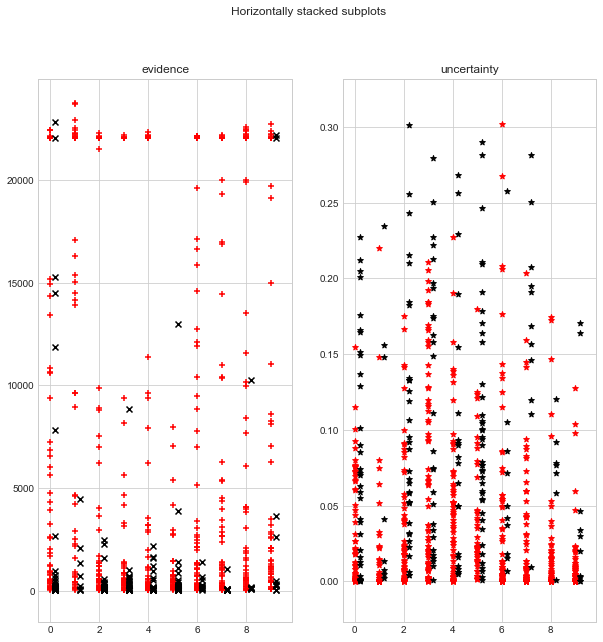

In [302]:
results = GetResultsCSV_evidence(model,(train_ds, test_ds, validation_ds),suffix="new_model", validation=True)

10000
labels
predictions complete, analyizing


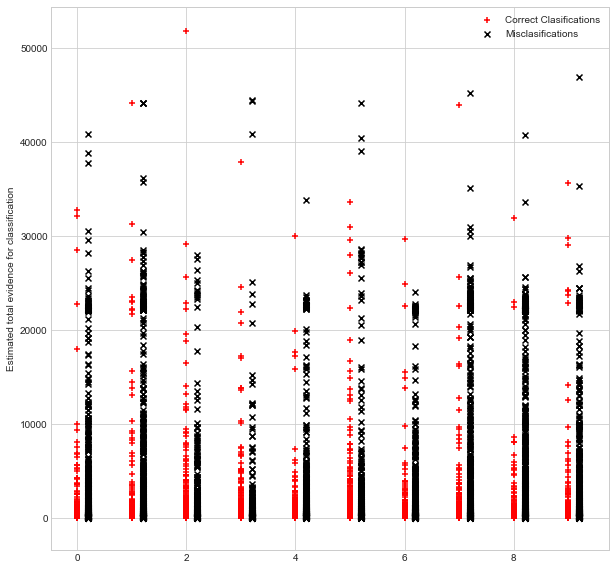

In [118]:
results = GetResultsCSV_evidence(new_model2,(train_ds, test_ds, validation_ds),suffix="new_model", validation=True)

In [22]:
train_acc1 =0.5948 
test_acc1 = 0.5976 
train_ev_s =5668.0684
train_ev_f =1607.4797
test_ev_s =3471.1299
test_ev_f =722.8594

In [23]:
def draw_EDL_results(train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f): 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    train_u_succ = K / (K+np.array(train_ev_s))
    train_u_fail = K / (K+np.array(train_ev_f))
    test_u_succ  = K / (K+np.array(test_ev_s))
    test_u_fail  = K / (K+np.array(test_ev_f))
    
    f, axs = pl.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(train_ev_s,c='r',marker='+')
    axs[0,0].plot(train_ev_f,c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(train_acc1,c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(test_ev_s,c='r',marker='+')
    axs[1,0].plot(test_ev_f,c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(test_acc1,c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    plt.show()

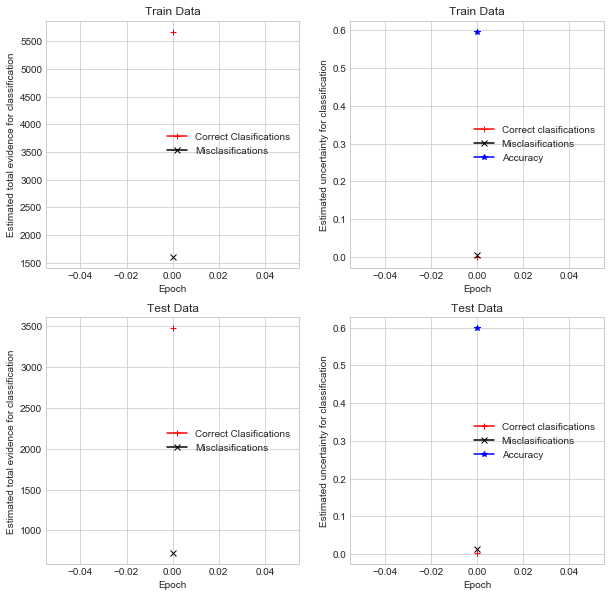

In [24]:
train_acc1 =0.5948 
test_acc1 = 0.5976 
train_ev_s =5668.0684
train_ev_f =1607.4797
test_ev_s =3471.1299
test_ev_f =722.8594
draw_EDL_results(train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f)